# Preditor de número de determinados comodos por função exercida

## Introdução

Com Base na lição 4 do curso Fast.ai, que visa introduzir os principios de machine learning utilizando NLP(Natural language Processing) traduzindo Processamento de Linguagem Natural.

### Objetivo

Utilizar de uma NLP para predizer dados sobre comodos de acordo com determinado traço profissional

 ### Preparando o ambiente
 
 Para preparar o ambiente, baixei numpy e o pandas, normalmente os mesmos já estão instalados nos ambientes kaggle

In [1]:
import numpy as np
import pandas as pd 

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

para a certificação de que o ambiente está configurado corretamente, instalamos os pacotes que o kaggle utiliza.

In [2]:
!pip install kaggle

Após isso preparamos os diretorios para depois incluirmos nosso dataset

In [3]:
creds = ''

In [4]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

Definimos então o nosso dataset

In [5]:
path = Path('us-patent-phrase-to-phrase-matching')
path

PosixPath('us-patent-phrase-to-phrase-matching')

In [6]:
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [7]:
if iskaggle:
    path = Path('../input/us-patent-phrase-to-phrase-matching')
    !pip install -q datasets

certificamos que o mesmo existe e está corretamente preenchido

In [8]:
!ls ../input/

us-patent-phrase-to-phrase-matching


In [9]:
!ls {path}

sample_submission.csv  test.csv  train.csv


In [10]:
df = pd.read_csv(path/'train.csv')

verificamos então o nosso dataset de treino

In [11]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [12]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [13]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor

In [14]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

tratamos este dataset

In [15]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(df)

In [16]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

Criamos então as funções para tokenizar as nossas palavras, que consiste em um processo de dividir as frases em palavras e transformar as palavras em número para que os mesmos possam ser usados para treinamento e validação

In [17]:
model_nm = 'microsoft/deberta-v3-small'

In [18]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:
tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['▁G',
 "'",
 'day',
 '▁folks',
 ',',
 '▁I',
 "'",
 'm',
 '▁Jeremy',
 '▁from',
 '▁fast',
 '.',
 'ai',
 '!']

In [20]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

Após isso fazemos alguns tratamentos para melhorar nosso dataset

In [21]:
def tok_func(x): return tokz(x["input"])

In [22]:
tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/37 [00:00<?, ?ba/s]

In [23]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

In [24]:
tokz.vocab['▁of']

265

renomeamos uma das colunas para melhor uso do mesmo

In [25]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

In [26]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


A partir daqui realizamos alguns testes com funções para sabermos qual está mais condizente com o resultado esperado

In [27]:
def f(x): return -3*x**2 + 2*x + 20

In [28]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

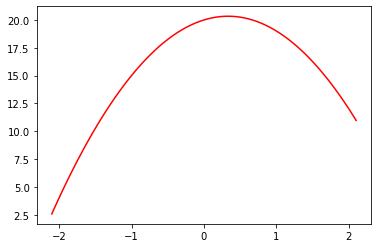

In [29]:
plot_function(f)

In [30]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

In [31]:
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

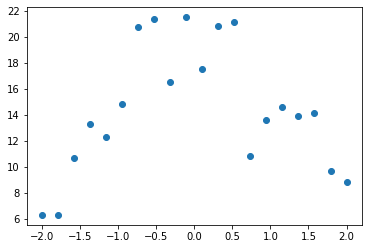

In [32]:
x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

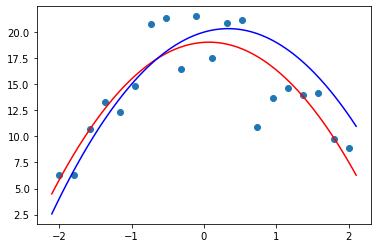

In [34]:
plot_poly(2)
plot_function(f, color='b')

In [35]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [36]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

Aqui então conseguimos filtrar os valores e visualizar os dados necessários para a predição

In [37]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


In [38]:
np.set_printoptions(precision=2, suppress=True)

np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [39]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [40]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)

0.6760250732906

In [41]:
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

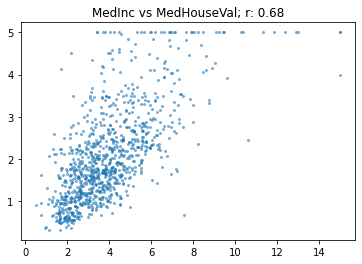

In [42]:
show_corr(housing, 'MedInc', 'MedHouseVal')

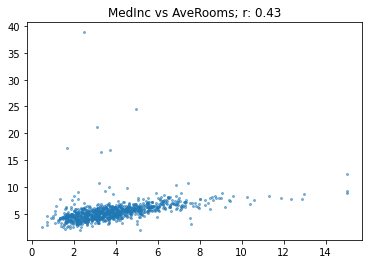

In [43]:
show_corr(housing, 'MedInc', 'AveRooms')

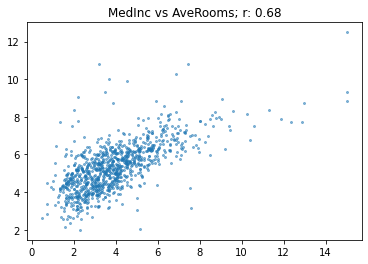

In [44]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

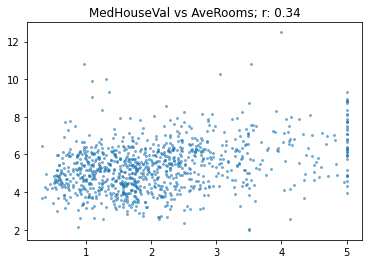

In [45]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

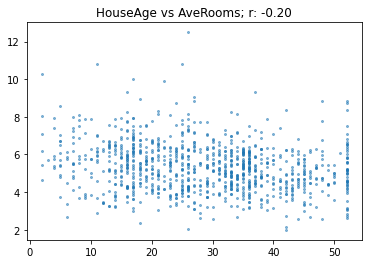

In [46]:
show_corr(subset, 'HouseAge', 'AveRooms')

In [47]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

In [48]:
from transformers import TrainingArguments,Trainer

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
bs = 128
epochs = 4

In [50]:
lr = 8e-5

In [51]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [52]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [53]:
trainer.train();

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, anchor, target, input, id. If context, anchor, target, input, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 27354
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 428
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.033992,0.782712
2,No log,0.023153,0.816923
3,No log,0.023065,0.824539
4,No log,0.023467,0.827347


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, anchor, target, input, id. If context, anchor, target, input, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 512
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, anchor, target, input, id. If context, anchor, target, input, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 512
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, anchor, target, input, id. If context, a

In [54]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, anchor, target, input, id. If context, anchor, target, input, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 36
  Batch size = 512


array([[ 0.6 ],
       [ 0.63],
       [ 0.52],
       [ 0.35],
       [-0.03],
       [ 0.56],
       [ 0.49],
       [-0.02],
       [ 0.33],
       [ 1.13],
       [ 0.22],
       [ 0.26],
       [ 0.72],
       [ 0.8 ],
       [ 0.74],
       [ 0.42],
       [ 0.26],
       [ 0.02],
       [ 0.64],
       [ 0.36],
       [ 0.36],
       [ 0.21],
       [ 0.13],
       [ 0.26],
       [ 0.6 ],
       [-0.03],
       [-0.03],
       [ 0.  ],
       [-0.04],
       [ 0.6 ],
       [ 0.3 ],
       [ 0.04],
       [ 0.71],
       [ 0.5 ],
       [ 0.43],
       [ 0.2 ]])

In [55]:
preds = np.clip(preds, 0, 1)
preds

array([[0.6 ],
       [0.63],
       [0.52],
       [0.35],
       [0.  ],
       [0.56],
       [0.49],
       [0.  ],
       [0.33],
       [1.  ],
       [0.22],
       [0.26],
       [0.72],
       [0.8 ],
       [0.74],
       [0.42],
       [0.26],
       [0.02],
       [0.64],
       [0.36],
       [0.36],
       [0.21],
       [0.13],
       [0.26],
       [0.6 ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.6 ],
       [0.3 ],
       [0.04],
       [0.71],
       [0.5 ],
       [0.43],
       [0.2 ]])

In [56]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

852